# **PARTE 1: Exploración inicial del dataset (EDA)**

Cargamos el dataset original


## **1.1 Carga del Dataset**

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../')

import utils.bootcampviztools as btz
import utils.utils as ut

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

df = pd.read_csv(r"C:\Users\patri\REPO_PRUEBA\ONLINE_DS_THEBRIDGE_Patricia_Diez\ML\Wholesale customers data.csv")

df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## **1.2 Descripción de variables**

| Nombre de columna     | Tipo de variable | Descripción                                                | Comentarios |
|----------------------|----------------|------------------------------------------------------------|-------------|
| Channel             | Categórica      | Canal de venta del cliente (Horeca(hotel, restaurante, cafe) o Minorista) | Convertido a categórico |
| Region              | Categórica      | Región geográfica del cliente (Lisboa, Oporto, Otro)      | Convertido a categórico |
| Fresh               | Numérica        | Gasto en productos frescos                                | Transformado logarítmicamente |
| Milk                | Numérica        | Gasto en productos lácteos                                | Transformado logarítmicamente |
| Grocery             | Numérica        | Gasto en productos de supermercado                        | Transformado logarítmicamente |
| Frozen              | Numérica        | Gasto en productos congelados                             | Transformado logarítmicamente |
| Detergents_Paper    | Numérica        | Gasto en productos de limpieza y papel                    | Transformado logarítmicamente |
| Delicassen          | Numérica        | Gasto en productos de delicatessen                        | Transformado logarítmicamente |


In [2]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [3]:
ut.data_report(df)

COL_N,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
DATA_TYPE,int64,int64,int64,int64,int64,int64,int64,int64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,2,3,433,421,430,426,417,403
CARDIN (%),0.45,0.68,98.41,95.68,97.73,96.82,94.77,91.59


## **1.3 Variables categóricas**

Ambas tienen baja cardinalidad, por lo que serán tratadas como variables categóricas.


In [4]:
df['Channel'] = df['Channel'].astype('object')
df['Region'] = df['Region'].astype('object')


In [5]:
features_cat = ut.get_features_cat(df)
features_cat

['Channel', 'Region']

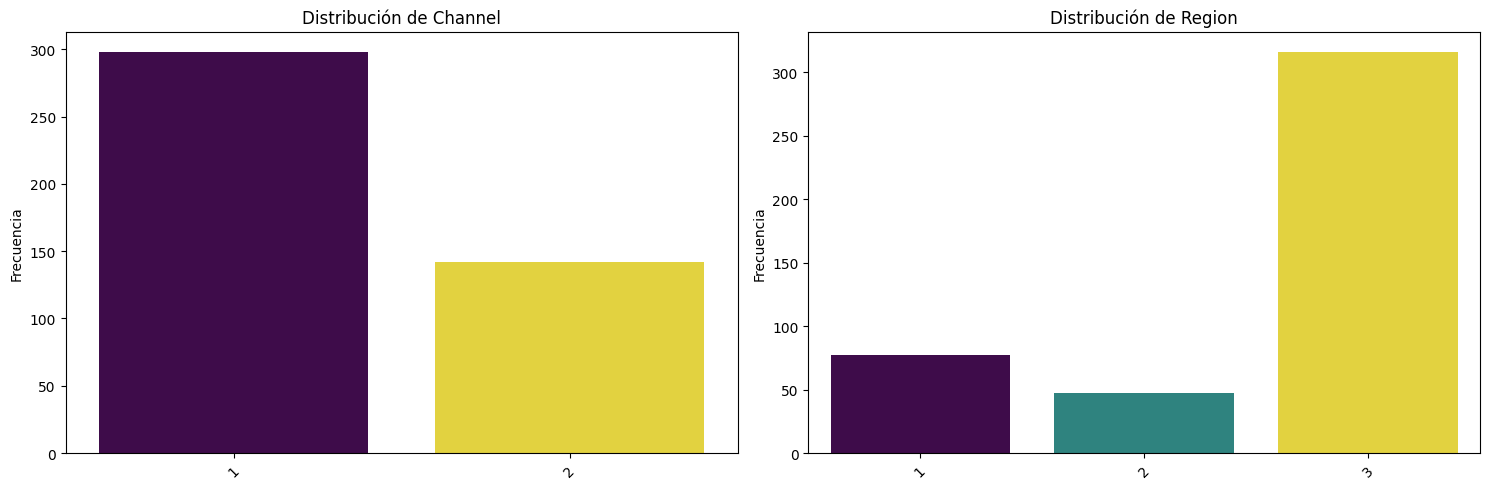

In [6]:
btz.pinta_distribucion_categoricas(df, features_cat)

- `Channel` tiene dos categorías: Horeca (1) y Retail (2).
- `Region` tiene tres regiones.


## **1.4 Variables numéricas + Skewness**

Las variables numéricas presentan distribuciones muy sesgadas hacia la derecha, lo que puede afectar al clustering.


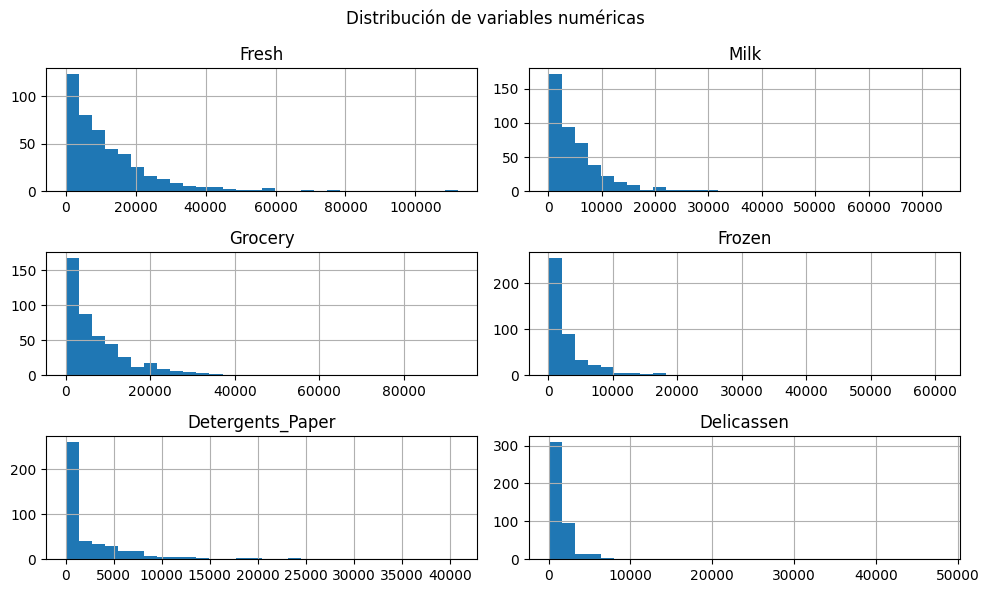

In [7]:
features_num = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df[features_num].hist(bins=30, figsize=(10,6))
plt.suptitle("Distribución de variables numéricas")
plt.tight_layout()
plt.show()


In [8]:
df.skew().sort_values(ascending= False)

Delicassen          11.151586
Frozen               5.907986
Milk                 4.053755
Detergents_Paper     3.631851
Grocery              3.587429
Fresh                2.561323
Channel              0.760951
Region              -1.283627
dtype: object

- La mayoría de las variables están  sesgadas hacia la derecha.
- Tiene sentido, unos pocos clientes gastan mucho más que el resto.
- Este sesgo puede afectar a algoritmos como K-Means. Por eso hacemos una transformación logarítmica.

## **1.5 Análisis de outliers**


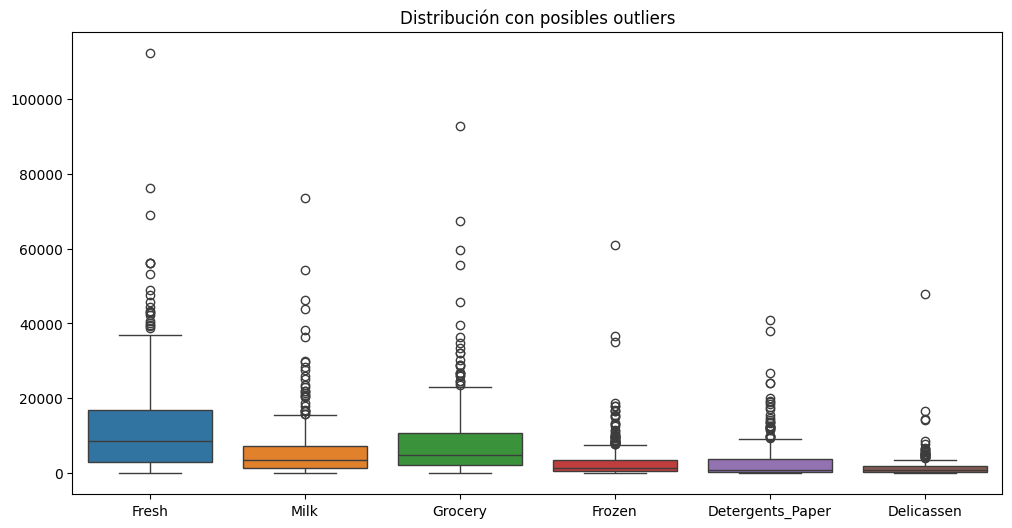

In [9]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[features_num])
plt.title("Distribución con posibles outliers")
plt.show()

In [10]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((df < lower_bound) | (df > upper_bound))
outliers_count = outliers_iqr.sum()

print("Número de outliers por variable (IQR):")
print(outliers_count)

print(f"Filas con al menos un outlier: {outliers_iqr.any(axis=1).sum()} de {len(df)}")

Número de outliers por variable (IQR):
Channel              0
Region               0
Fresh               20
Milk                28
Grocery             24
Frozen              43
Detergents_Paper    30
Delicassen          27
dtype: int64
Filas con al menos un outlier: 108 de 440


- Las variables numéricas tienen bastantes outliers
- Tenemso que hacer transformaciones como logaritmos o escalado

## **1.6 Correlación entre variables**

In [11]:
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df_selected = df[features]

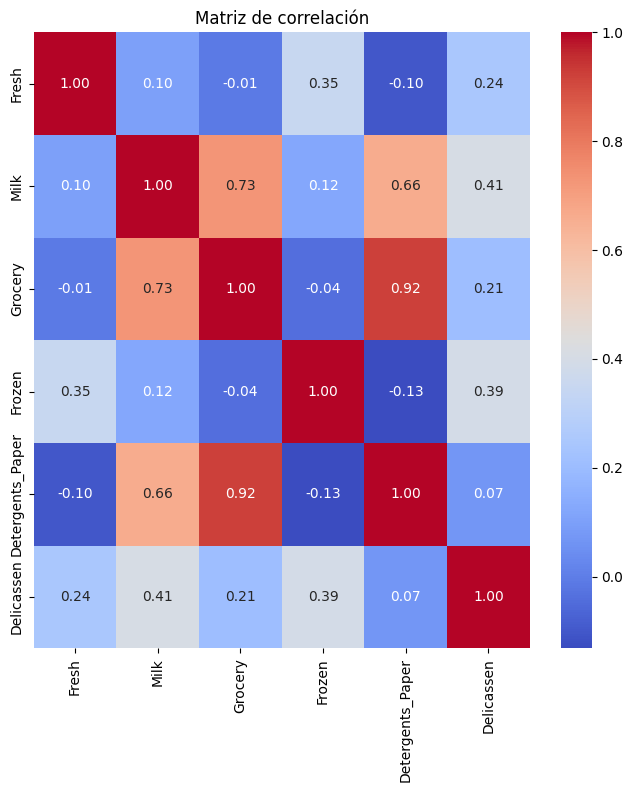

In [12]:
plt.figure(figsize=(8, 8))
sns.heatmap(df[features_num].corr(), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Matriz de correlación")
plt.show()


Correlaciones altas entre:
- **Grocery y Detergents_Paper** (≈ 0.92)
- **Milk y Grocery** (≈ 0.73)
- **Milk y Detergents_Paper** (≈ 0.66)


## **1.7 Transformaciones (Log + Escalado)**

In [13]:
df_log = np.log1p(df[features_num])

scaler = MinMaxScaler()
df_scaled_log = pd.DataFrame(scaler.fit_transform(df_log), columns=features_num)

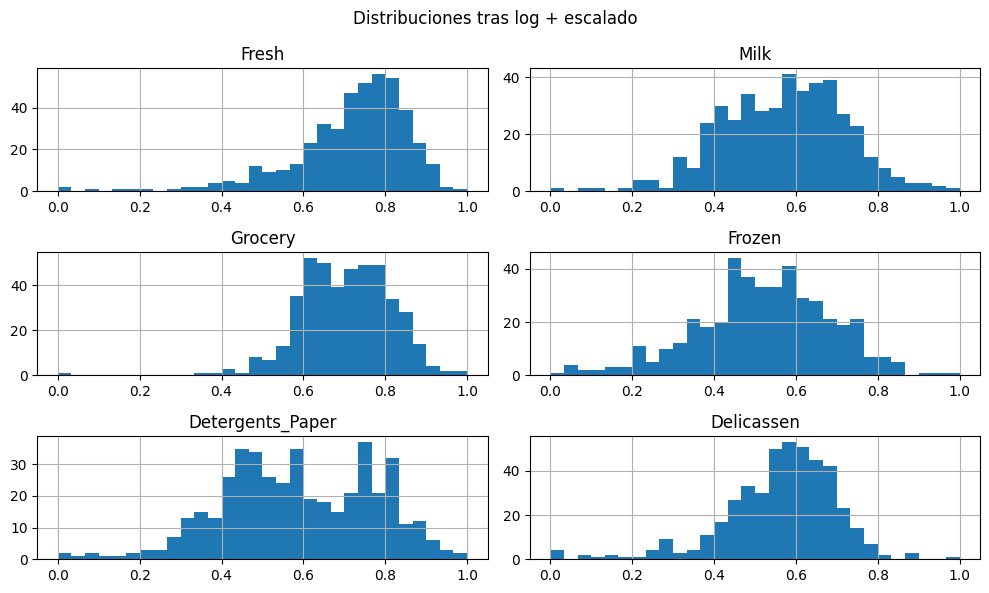

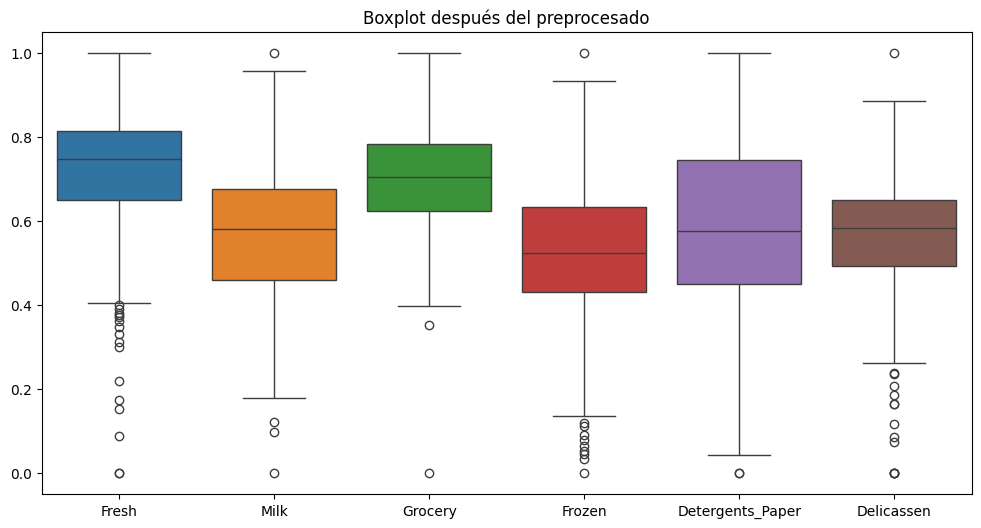

In [14]:
df_scaled_log.hist(bins=30, figsize=(10,6))
plt.suptitle("Distribuciones tras log + escalado")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df_scaled_log)
plt.title("Boxplot después del preprocesado")
plt.show()


- Hacemos `log1p` a las variables numéricas para reducir la asimetría y los outliers.
- Usamos`MinMaxScaler` para escalar todas las variables entre 0 y 1.

## **1.8 Dataset final limpio**

Unimos la parte numérica transformada con la variable categórica `Channel`.  
La columna `Region` se elimina porque no aporta información relevante tras el análisis.



In [15]:
df_encoded = pd.get_dummies(df['Channel'], prefix='Channel', drop_first=True)

df_final = pd.concat([df_scaled_log.reset_index(drop=True), df_encoded], axis=1)

df_final.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_2
0,0.787076,0.717315,0.750579,0.272291,0.704748,0.619005,True
1,0.729947,0.719518,0.773997,0.543498,0.727298,0.649139,True
2,0.719687,0.704513,0.752184,0.583577,0.734394,0.807256,True
3,0.791565,0.426513,0.692596,0.709778,0.524784,0.649856,False
4,0.843653,0.636636,0.745685,0.646361,0.660499,0.763182,True


In [16]:
df_final.to_csv(r"C:\Users\patri\REPO_PRUEBA\ML_Customer_Segmentation\src\data_sample\wholesale_customers_final.csv", index=False)

# **PARTE 2: Clustering Analysis - Con y Sin PCA** 

### **2.1 KMeans sin PCA (codo + silhouette)**

In [17]:
X = df_final.copy()

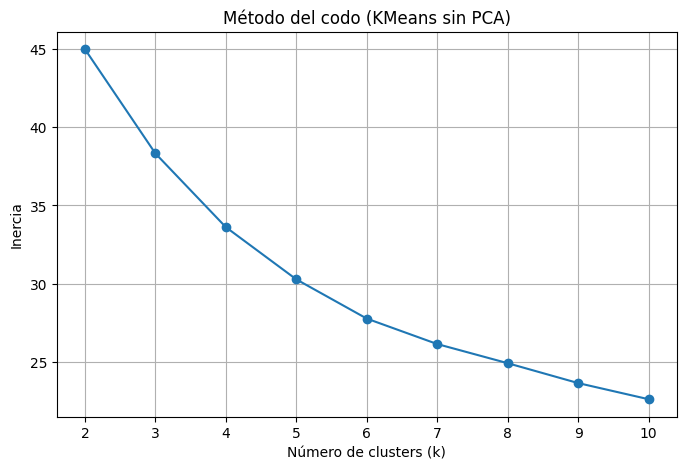

In [18]:
inertia = []
k_range = range(2, 11) 

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)  
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Método del codo (KMeans sin PCA)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

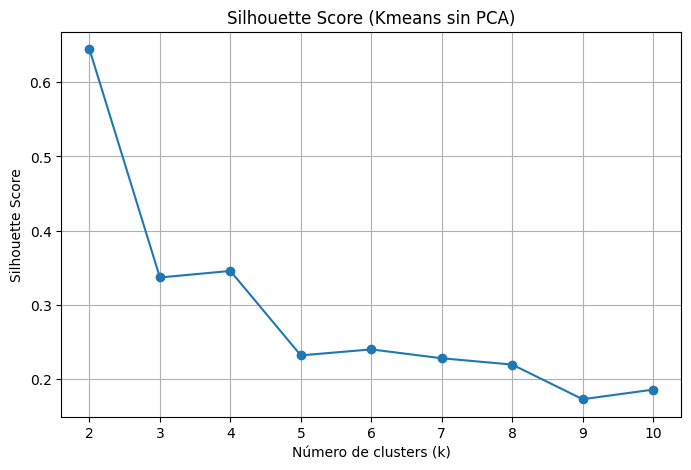

In [19]:
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouettes.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouettes, marker='o')
plt.title("Silhouette Score (Kmeans sin PCA)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

- Aplicamos el algoritmo K-Means directamente sobre los datos escalados y transformados.
- Probamos con valores de `k` de 2 a 10.
- Con el **método del codo** observamos la inercia.
- Calculamos **Silhouette Score** para evaluar la calidad de los clusters.
- `k=2` da la mejor separación de grupos.


###  **2.2 Evaluación KMeans sin PCA**

Calculamos el Silhouette Score para los valores de `k=2`, `k=3` y `k=4`. 

El mejor resultado es con `k=2`, por lo que este será el valor de referencia para comparar con otros algoritmos de clustering.


In [20]:
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_2 = kmeans_2.fit_predict(X)
df_final["Cluster_2"] = labels_2

score_2 = silhouette_score(X, labels_2)
print(f"Silhouette Score (k=2): {score_2:.3f}")

Silhouette Score (k=2): 0.644


In [21]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(X)
df_final["Cluster_3"] = labels_3

score_3 = silhouette_score(X, labels_3)
print(f"Silhouette Score (k=3): {score_3:.3f}")

Silhouette Score (k=3): 0.337


In [22]:
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = kmeans_4.fit_predict(X)
df_final["Cluster_4"] = labels_4

score_4 = silhouette_score(X, labels_4)
print(f"Silhouette Score (k=4): {score_4:.3f}")

Silhouette Score (k=4): 0.346


In [23]:
cols_originales = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen', 'Channel_2']

df_cluster2 = df_final.drop(columns=["Cluster_3", "Cluster_4"], errors='ignore')

df_cluster2.groupby("Cluster_2")[cols_originales].mean().style.highlight_max(axis=0)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_2
Cluster_2,,,,,,,
0,0.682126,0.696264,0.808018,0.462791,0.780437,0.588881,1.000000
1,0.734122,0.510625,0.651425,0.549290,0.492744,0.550257,0.000000


###  **2.3 PCA (análisis de varianza)**

Aplicamos PCA para reducir las dimensiones del dataset y facilitar la visualización de los clusters. Con sólo 4 componentes se conserva más del 90% de la varianza-


In [24]:
# PCA exploratorio (para calcular cuánta varianza explican todas las componentes)
pca = PCA()
x_pca = pca.fit_transform(X)

Varianza explicada por cada componente: [0.72267852 0.10498056 0.06662707 0.04075552 0.03583427 0.02130447
 0.00781958]
Varianza acumulada: [0.72267852 0.82765909 0.89428616 0.93504168 0.97087595 0.99218042
 1.        ]


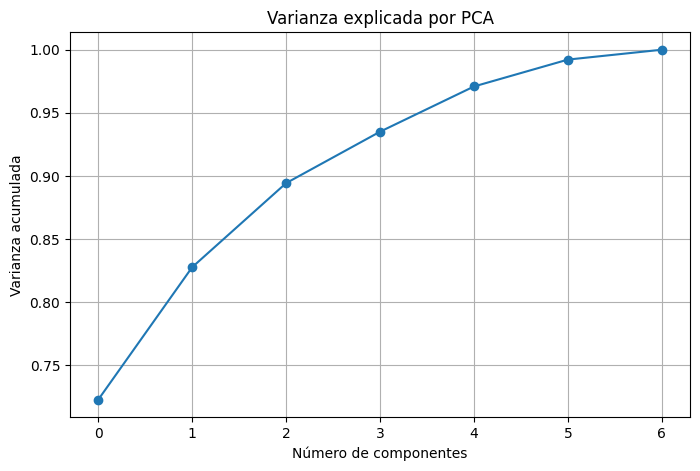

In [25]:
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)
print("Varianza acumulada:", np.cumsum(explained_variance))

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza explicada por PCA')
plt.grid(True)
plt.show()

Con solo 2 o 3 componentes tenemos la mayor parte de la información relevante.  

Elegimos 4 componentes para asegurar que no perdemos demasiada info.


### **2.4 KMeans con PCA**

In [26]:
# Reducimos a 4 componentes
pca_final = PCA(n_components=4)
X_pca = pca_final.fit_transform(X)

kmeans_pca = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)

df_final["Cluster_PCA"] = labels_pca

silhouette_pca = silhouette_score(X_pca, labels_pca)
print(f"Silhouette Score (PCA + KMeans, k=2): {silhouette_pca:.3f}")

Silhouette Score (PCA + KMeans, k=2): 0.690


El Silhouette Score con PCA es un poco mayor al sin PCA

### **2.5 Visualización Clusters**


Usamos los dos primeros componentes principales para representar los datos en dos dimensiones y ver cómo se distribuyen los clientes según su cluster. 


In [27]:
X_pca_2d = X_pca[:, :2] 

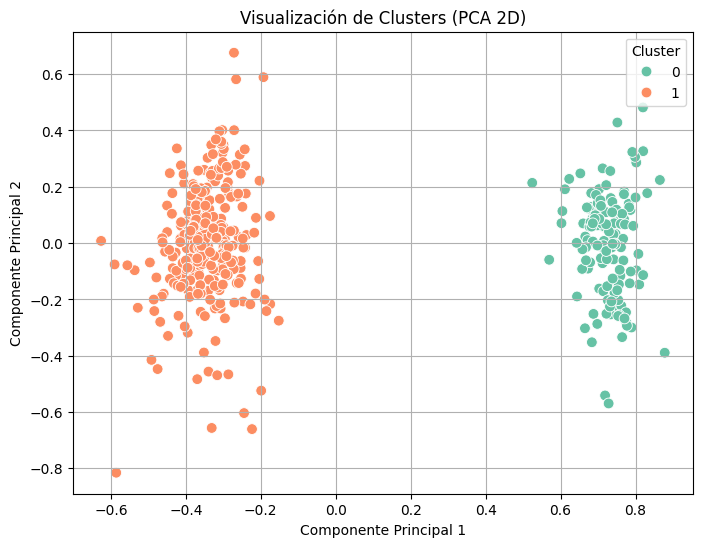

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca_2d[:, 0],
    y=X_pca_2d[:, 1],
    hue=df_final["Cluster_PCA"],
    palette='Set2',
    s=60
)
plt.title("Visualización de Clusters (PCA 2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


Una vez realizados los clusters, analizamos las características **promedio** de cada grupo, para crear perfiles de cliente. 


In [29]:
cols_originales = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen', 'Channel_2']

df_final[cols_originales + ['Cluster_PCA']].groupby("Cluster_PCA").mean().style.highlight_max(axis=0)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_2
Cluster_PCA,,,,,,,
0,0.682126,0.696264,0.808018,0.462791,0.780437,0.588881,1.000000
1,0.734122,0.510625,0.651425,0.549290,0.492744,0.550257,0.000000


- **Cluster 0** tiene un mayor gasto en:
  - `Grocery`, `Milk` y `Detergents_Paper`, por lo que probablemnete son los **clientes tipo retail** (tiendas o supermercados)..
- **Cluster 1** consume más de `Fresh` y `Frozen`, y menos en productos de supermercado. Podría representar a restaurantes, hoteles, etc.

Comparamos los resultados k-means con PCA, y sin él, usando los datos reducidos a 2 dimensiones. Esto nos permite ver qué tan bien están separados los grupos en cada caso.


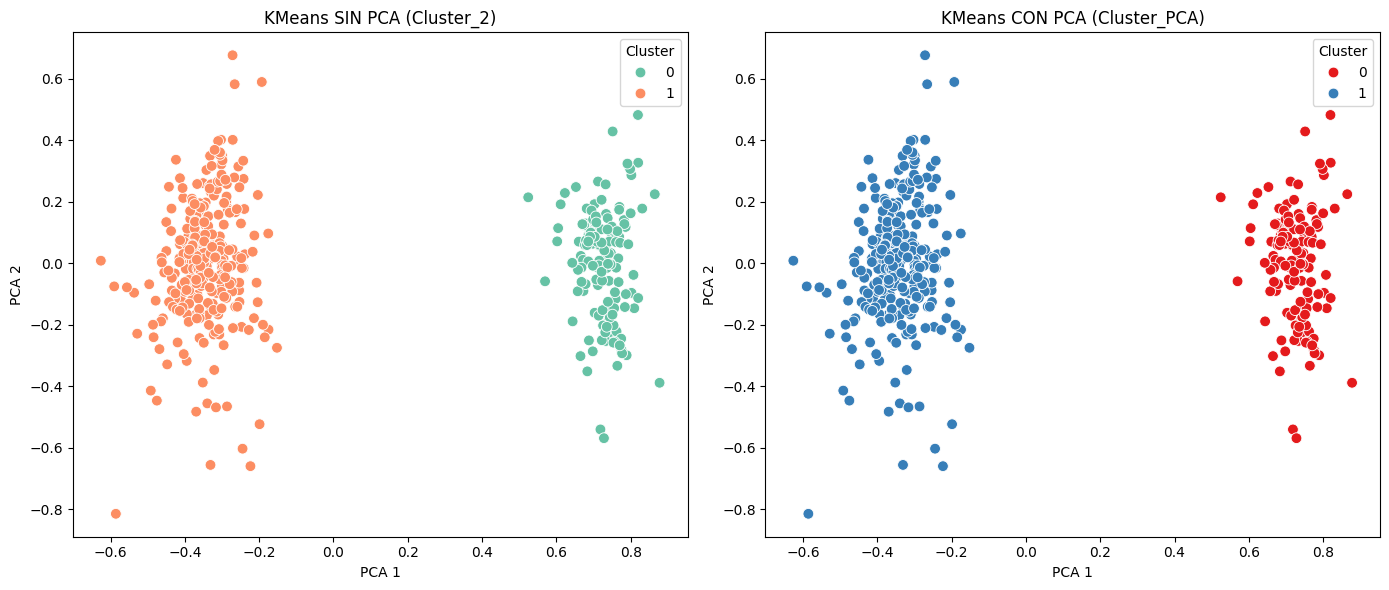

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Visualización de KMeans sin PCA
sns.scatterplot(
    x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
    hue=df_final["Cluster_2"],
    palette='Set2', s=60, ax=axes[0]
)
axes[0].set_title("KMeans SIN PCA (Cluster_2)")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")
axes[0].legend(title="Cluster")

# Visualización de KMeans con PCA
sns.scatterplot(
    x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
    hue=df_final["Cluster_PCA"],
    palette='Set1', s=60, ax=axes[1]
)
axes[1].set_title("KMeans CON PCA (Cluster_PCA)")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")
axes[1].legend(title="Cluster")

plt.tight_layout()
plt.show()


### **2.6 DBSCAN & Agglomerative**

Probamos otros modelos como DBSCAN y Agglomerative Clustering con K-Means. 


In [31]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_pca_2d)

df_final["Cluster_DBSCAN"] = labels_dbscan

n_noise = np.sum(labels_dbscan == -1)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)

# Silhouette Score solo si hay más de un cluster válido
if n_clusters_dbscan > 1:
    score_dbscan = silhouette_score(X_pca_2d[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1])
    print(f"Silhouette Score (DBSCAN): {score_dbscan:.3f} (Outliers: {n_noise})")
else:
    score_dbscan = -1
    print("DBSCAN no encontró clusters válidos")


Silhouette Score (DBSCAN): 0.789 (Outliers: 1)


In [32]:
agglo = AgglomerativeClustering(n_clusters=2)
labels_agglo = agglo.fit_predict(X_pca_2d)

df_final["Cluster_Agglo"] = labels_agglo

score_agglo = silhouette_score(X_pca_2d, labels_agglo)
print(f"Silhouette Score (Agglomerative, k=2): {score_agglo:.3f}")


Silhouette Score (Agglomerative, k=2): 0.787


### **2.7 Comparación de modelos**

Comparamos los resultados de los tres algoritmos de clustering usando los datos reducidos a 2 dimensiones.

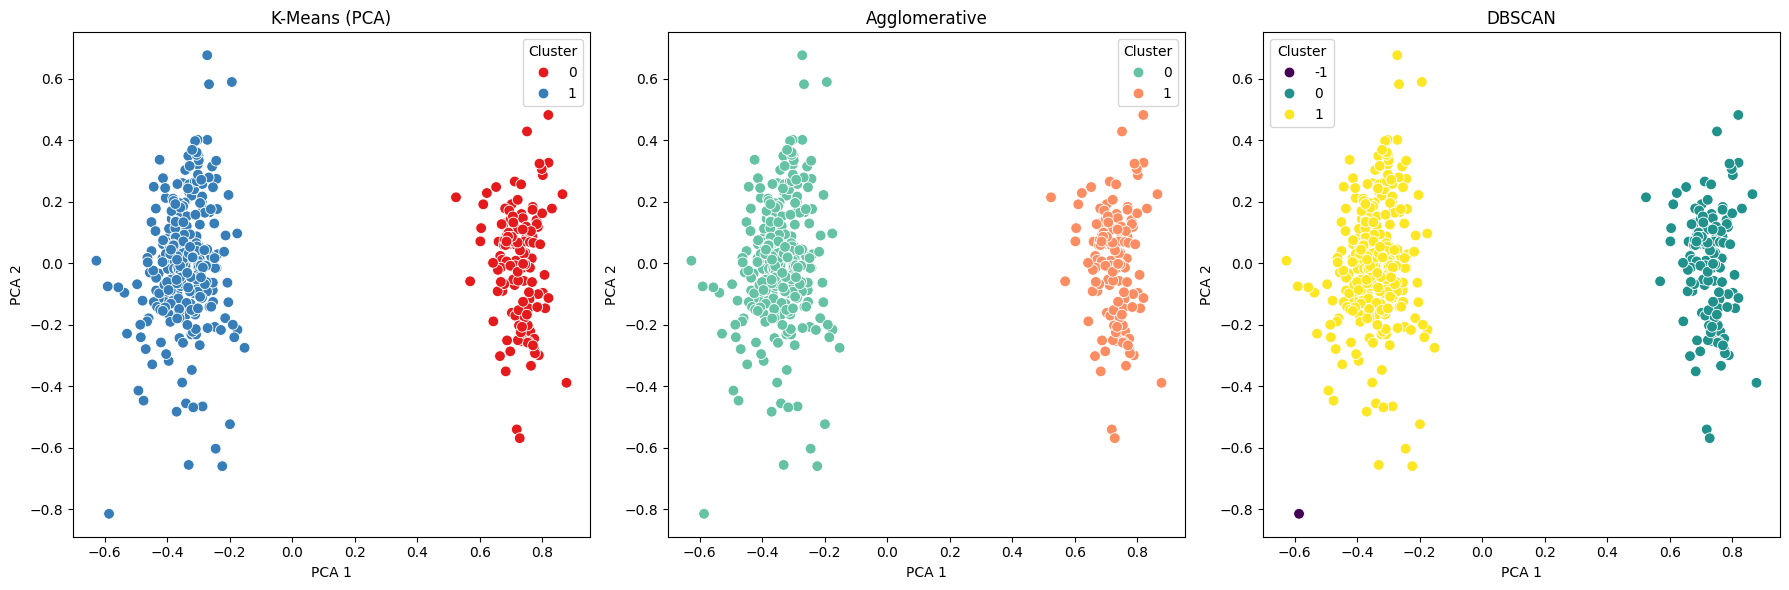

In [33]:
plt.figure(figsize=(18, 6))

# K-Means con PCA
plt.subplot(1, 3, 1)
sns.scatterplot(
    x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
    hue=df_final["Cluster_PCA"],
    palette='Set1', s=60
)
plt.title("K-Means (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")

# Agglomerative Clustering
plt.subplot(1, 3, 2)
sns.scatterplot(
    x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
    hue=df_final["Cluster_Agglo"],
    palette='Set2', s=60
)
plt.title("Agglomerative")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")

# DBSCAN
plt.subplot(1, 3, 3)
sns.scatterplot(
    x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
    hue=df_final["Cluster_DBSCAN"],
    palette='viridis', s=60
)
plt.title("DBSCAN")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")

plt.tight_layout()
plt.show()


In [34]:
print(f"Silhouette Score (PCA + KMeans, k=2): {silhouette_pca:.3f}")
print(f"Silhouette Score (DBSCAN): {score_dbscan:.3f}")
print(f"Silhouette Score (Agglomerative, k=2): {score_agglo:.3f}")

Silhouette Score (PCA + KMeans, k=2): 0.690
Silhouette Score (DBSCAN): 0.789
Silhouette Score (Agglomerative, k=2): 0.787


Aunque DBSCAN y Agglomerative tienen mejores Silhouette Scores, elegimos **KMeans con PCA** como modelo final:

- Simplicidad
- Buena separación de los grupos
- Es más estable que DBSCAN
- Ayuda a interpretar perfiles de cliente más fácilemnte.

In [35]:
import joblib

joblib.dump(kmeans_pca, r"C:\Users\patri\REPO_PRUEBA\ML_Customer_Segmentation\src\models\kmeans_pca_model.pkl")
joblib.dump(dbscan, r"C:\Users\patri\REPO_PRUEBA\ML_Customer_Segmentation\src\models\dbscan_model.pkl")
joblib.dump(agglo, r"C:\Users\patri\REPO_PRUEBA\ML_Customer_Segmentation\src\models\agglomerative_model.pkl")

joblib.dump(pca_final, r"C:\Users\patri\REPO_PRUEBA\ML_Customer_Segmentation\src\models\pca_model.pkl")

print("Modelos guardados correctamente.")


Modelos guardados correctamente.


### **2.8 Conclusiones**

El proyecto ha consistido en:

1. **EDA y preprocesado**:
   - Encontramos variables numéricas con alta asimetría hacía la derecha y outliers.
   - Aplicamos transformación logarítmica + escalado.
   - Eliminamos la variable `Region`.
   - Codificamos `Channel`.

2. **Clustering con diferentes enfoques**:
   - **KMeans** con y sin reducción de dimensión con PCA.
   - **DBSCAN** y **Agglomerative Clustering**.
   - Todos los modelos son evaluados con **Silhouette Score**.
---

### 📊 **Comparación de Modelos de Clustering**

| Algoritmo               | Silhouette Score | Observaciones                                                             |
|-------------------------|------------------|---------------------------------------------------------------------------|
| **KMeans (sin PCA)**    | 0.64             | Buen resultado              |
| **KMeans (con PCA)**    | 0.69             | Mejora                           |
| **DBSCAN**              | 0.79             | Mejor resultado, pero muy sensible a los parámetros y hay ruido|
| **Agglomerative**       | 0.78             | Muy buen resultado                        |

---

### ✅ **Modelo Final Elegido**

Optamos por **KMeans con PCA (k=2)** como modelo final por su:

- estabilidad
- simplicidad
- interpretabilidad

---

### 🔄 **Posibles Mejoras y Futuros Pasos**

Aunque el modelo final está bien, hay oportunidades para mejorar y extender este análisis:

1. **Optimización de parámetros**:
   - Ajustar los hiperparámetros de DBSCAN (`eps`, `min_samples`) usando un grid searcht.
   - Explorar más valores de `k` para KMeans o usar métodos automáticos.

2. **Detección y tratamiento de outliers**:
   - Investigar técnicas de *outlier detection* previas al clustering.
   - Evaluar el impacto de eliminar outliers sobre los resultados de clustering.

---

### 🎯 **Conclusión**

Este proyecto demuestra cómo técnicas de reducción de dimensionalidad y distintos algoritmos de clustering pueden combinarse para crear una **segmentación de clientes**. Esto puede facilitar mejores decisiones en marketing, atención personalizada y diseño de productos.
